<a href="https://colab.research.google.com/github/Ravindu-Pathirana/HealthCare/blob/main/EchoBinary_notebook_ClassifierModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Mental Health Risk Prediction Notebook

Date: 03.01.26

## Reproducibility

In [2]:
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## Imports and Setup

This section imports all necessary Python libraries for data handling, preprocessing, visualization, and machine learning.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    StackingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

print("All imports successful.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
All imports successful.


## Load Dataset
Load the survey dataset and inspect its shape, columns, and first few rows. Drop unnecessary columns such as 'Timestamp'.


In [13]:
df = pd.read_csv('/smmh.csv')  # Please upload 'smmh.csv' to your Colab environment or specify the correct path.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
  df.shape

(481, 21)

In [15]:
df.columns

Index(['Timestamp', '1. What is your age?', '2. Gender',
       '3. Relationship Status', '4. Occupation Status',
       '5. What type of organizations are you affiliated with?',
       '6. Do you use social media?',
       '7. What social media platforms do you commonly use?',
       '8. What is the average time you spend on social media every day?',
       '9. How often do you find yourself using Social media without a specific purpose?',
       '10. How often do you get distracted by Social media when you are busy doing something?',
       '11. Do you feel restless if you haven't used Social media in a while?',
       '12. On a scale of 1 to 5, how easily distracted are you?',
       '13. On a scale of 1 to 5, how much are you bothered by worries?',
       '14. Do you find it difficult to concentrate on things?',
       '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
       '16. Following the previous question, 

In [16]:
df.head()
df.drop(columns=['Timestamp'], inplace=True)

In [17]:
df.head()

,1. What is your age?,2. Gender,3. Relationship Status,4. Occupation Status,5. What type of organizations are you affiliated with?,6. Do you use social media?,7. What social media platforms do you commonly use?,8. What is the average time you spend on social media every day?,9. How often do you find yourself using Social media without a specific purpose?,10. How often do you get distracted by Social media when you are busy doing something?,11. Do you feel restless if you haven't used Social media in a while?,"12. On a scale of 1 to 5, how easily distracted are you?","13. On a scale of 1 to 5, how much are you bothered by worries?",14. Do you find it difficult to concentrate on things?,"15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?","16. Following the previous question, how do you feel about these comparisons, generally speaking?",17. How often do you look to seek validation from features of social media?,18. How often do you feel depressed or down?,"19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?","20. On a scale of 1 to 5, how often do you face issues regarding sleep?"
0,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,3,2,5,2,5,2,3,2,5,4,5
1,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,3,2,4,5,4,5,1,1,5,4,5
2,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,2,1,2,5,4,3,3,1,4,2,5
3,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,2,1,3,5,3,5,1,2,4,3,2
4,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,5,4,4,5,5,3,3,3,4,4,1


## Rename Columns
Simplify column names for readability and easier handling in preprocessing and modeling.


In [ ]:
columns_names = {
    "1. What is your age?":"age",
    "2. Gender":"gender",
    "3. Relationship Status":"relationship",
    "4. Occupation Status":"occupation",
    "5. What type of organizations are you affiliated with?":"affiliation",
    "6. Do you use social media?":"use_sm",
    "7. What social media platforms do you commonly use?":"types_sm",
    "8. What is the average time you spend on social media every day?":"avg. time",
    "9. How often do you find yourself using Social media without a specific purpose?":"purpose_sm",
    "10. How often do you get distracted by Social media when you are busy doing something?":"distract_sm",
    "11. Do you feel restless if you haven't used Social media in a while?":"restless_sm",
    "12. On a scale of 1 to 5, how easily distracted are you?":"distraction",
    "13. On a scale of 1 to 5, how much are you bothered by worries?":"worries",
    "14. Do you find it difficult to concentrate on things?":"deconcentration ",
    "15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?":"people_compare",
    "16. Following the previous question, how do you feel about these comparisons, generally speaking?":"compare_status",
    "17. How often do you look to seek validation from features of social media?":"validation",
    "18. How often do you feel depressed or down?":"depression",
    "19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?":"fluctuate",
    "20. On a scale of 1 to 5, how often do you face issues regarding sleep?":"sleep_issues"
}

df = df.rename(columns=columns_names)

In [ ]:
df.columns

Index(['age', 'gender', 'relationship', 'occupation', 'affiliation', 'use_sm',
       'types_sm', 'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm',
       'distraction', 'worries', 'deconcentration ', 'people_compare',
       'compare_status', 'validation', 'depression', 'fluctuate',
       'sleep_issues'],
      dtype='object')

## Data Cleaning
- Normalize gender labels to standard categories.
- Remove respondents who do not use social media.
- Drop unused columns related to social comparison and validation.


In [ ]:
for i in df.columns:
  print(df[i].value_counts().sort_index())
  print('-*'*100)

age
13.0     2
14.0     4
15.0     2
16.0     2
17.0     9
18.0    13
19.0    19
20.0    45
21.0    82
22.0    81
23.0    42
24.0    27
25.0    17
26.0    18
26.7     1
27.0    11
28.0     5
29.0     6
30.0     6
31.0     1
32.0     4
33.0     2
34.0     6
35.0     8
36.0     3
37.0     4
38.0     3
40.0     2
42.0     1
43.0     1
44.0     2
45.0     1
46.0     2
47.0    16
48.0    13
49.0     3
50.0     6
51.0     2
52.0     1
53.0     1
55.0     1
56.0     2
60.0     1
65.0     1
69.0     1
91.0     1
Name: count, dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
gender
Female                 263
Male                   211
NB                       1
Non binary               1
Non-binary               1
Nonbinary                1
There are others???      1
Trans                    1
unsure                   1
Name: count, 

In [ ]:
df.drop(columns=['people_compare','compare_status','validation'], inplace=True)
df.head()

,age,gender,relationship,occupation,affiliation,use_sm,types_sm,avg. time,purpose_sm,distract_sm,restless_sm,distraction,worries,deconcentration,depression,fluctuate,sleep_issues
0,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,3,2,5,2,5,5,4,5
1,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,3,2,4,5,4,5,4,5
2,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,2,1,2,5,4,4,2,5
3,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,2,1,3,5,3,4,3,2
4,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,5,4,4,5,5,4,4,1


In [ ]:
df.dtypes

,0
age,float64
gender,object
relationship,object
occupation,object
affiliation,object
use_sm,object
types_sm,object
avg. time,object
purpose_sm,int64
distract_sm,int64


In [ ]:
df['age'].dtype

dtype('float64')

In [ ]:
df['age'] = df['age'].astype('int64')

In [ ]:
df['gender'].value_counts()

,count
gender,
Female,263
Male,211
Nonbinary,1
Non-binary,1
NB,1
unsure,1
Trans,1
Non binary,1
There are others???,1


In [ ]:
gender_v = {'Female' : 'female',
         'Male' : 'male',
         'Non-binary':'others',
         'Nonbinary ' : 'others',
         'NB' : 'others',
         'unsure ' : 'others',
         'Non binary ' : 'others',
         'Trans' : 'others',
          'There are others???':'others' }

df['gender'] = df['gender'].replace(gender_v)
df.gender.value_counts()

,count
gender,
female,263
male,211
others,7


In [ ]:
df.drop(df.loc[df['use_sm'] == 'No'].index, inplace=True)
df.drop(columns=['use_sm'], inplace=True)
df.columns

Index(['age', 'gender', 'relationship', 'occupation', 'affiliation',
       'types_sm', 'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm',
       'distraction', 'worries', 'deconcentration ', 'depression', 'fluctuate',
       'sleep_issues'],
      dtype='object')

## Social Media Platform Processing
- Convert the 'types_sm' column into lowercase and remove special characters.
- Split comma-separated social media types into a list.
- Apply MultiLabelBinarizer to create binary columns for each platform.


In [ ]:
df['types_sm'].value_counts()

,count
types_sm,
"Facebook, Instagram, YouTube",35
"Facebook, YouTube",30
"Facebook, Instagram, YouTube, Snapchat",28
"Facebook, Instagram, YouTube, Snapchat, Discord",19
"Facebook, Instagram, YouTube, Discord",18
...,...
"Facebook, Instagram, YouTube, Reddit, TikTok",1
"Facebook, Twitter, YouTube, Pinterest",1
"Instagram, Discord",1


In [ ]:
df['types_sm'] = (
    df['types_sm']
    .astype(str)
    .str.lower()
    .str.replace(r"[\[\]']", "", regex=True)
    .str.strip()
    .str.split(r",\s*")
)


mlb = MultiLabelBinarizer()
platform_df = pd.DataFrame(
    mlb.fit_transform(df['types_sm']),
    columns=[f'platform_{p}' for p in mlb.classes_],
    index=df.index
)

df = pd.concat([df.drop(columns=['types_sm']), platform_df], axis=1)
df.head()


,age,gender,relationship,occupation,affiliation,avg. time,purpose_sm,distract_sm,restless_sm,distraction,...,sleep_issues,platform_discord,platform_facebook,platform_instagram,platform_pinterest,platform_reddit,platform_snapchat,platform_tiktok,platform_twitter,platform_youtube
0,21,male,In a relationship,University Student,University,Between 2 and 3 hours,5,3,2,5,...,5,1,1,1,0,1,0,0,1,1
1,21,female,Single,University Student,University,More than 5 hours,4,3,2,4,...,5,1,1,1,0,1,0,0,1,1
2,21,female,Single,University Student,University,Between 3 and 4 hours,3,2,1,2,...,5,0,1,1,1,0,0,0,0,1
3,21,female,Single,University Student,University,More than 5 hours,4,2,1,3,...,2,0,1,1,0,0,0,0,0,0
4,21,female,Single,University Student,University,Between 2 and 3 hours,3,5,4,4,...,1,0,1,1,0,0,0,0,0,1


In [ ]:
df.columns

Index(['age', 'gender', 'relationship', 'occupation', 'affiliation',
       'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm', 'distraction',
       'worries', 'deconcentration ', 'depression', 'fluctuate',
       'sleep_issues', 'platform_discord', 'platform_facebook',
       'platform_instagram', 'platform_pinterest', 'platform_reddit',
       'platform_snapchat', 'platform_tiktok', 'platform_twitter',
       'platform_youtube'],
      dtype='object')

In [ ]:
df.isna().sum()

,0
age,0
gender,0
relationship,0
occupation,0
affiliation,30
avg. time,0
purpose_sm,0
distract_sm,0
restless_sm,0
distraction,0


In [ ]:
for i in df.columns:
  print(df[i].value_counts().sort_index())
  print('=='*50)

age
13     2
14     4
15     2
16     2
17     9
18    13
19    19
20    44
21    82
22    81
23    42
24    27
25    17
26    18
27    11
28     5
29     6
30     6
31     1
32     4
33     2
34     6
35     8
36     3
37     4
38     3
40     2
42     1
43     1
44     2
45     1
46     2
47    16
48    13
49     3
50     5
51     2
52     1
53     1
55     1
56     2
60     1
65     1
69     1
91     1
Name: count, dtype: int64
gender
female    263
male      208
others      7
Name: count, dtype: int64
relationship
Divorced               6
In a relationship     87
Married              101
Single               284
Name: count, dtype: int64
occupation
Retired                 8
Salaried Worker       130
School Student         49
University Student    291
Name: count, dtype: int64
affiliation
Company                            29
Company, Private                    7
Goverment                           6
Private                            59
School                             44
School, 

In [ ]:
df.columns

Index(['age', 'gender', 'relationship', 'occupation', 'affiliation',
       'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm', 'distraction',
       'worries', 'deconcentration ', 'depression', 'fluctuate',
       'sleep_issues', 'platform_discord', 'platform_facebook',
       'platform_instagram', 'platform_pinterest', 'platform_reddit',
       'platform_snapchat', 'platform_tiktok', 'platform_twitter',
       'platform_youtube'],
      dtype='object')

## Map Average Time
Convert categorical average time ranges into numerical values for modeling.


In [ ]:
df['avg. time'].value_counts()

,count
avg. time,
More than 5 hours,116
Between 2 and 3 hours,101
Between 3 and 4 hours,93
Between 1 and 2 hours,68
Between 4 and 5 hours,67
Less than an Hour,33


In [ ]:
time_map = {
    'Between 1 and 2 hours': 1,
    'Between 2 and 3 hours':2,
    'Between 3 and 4 hours' :3,
    'Between 4 and 5 hours':4,
    'Less than an Hour':0,
    'More than 5 hours': 5        }

df['avg. time'] = df['avg. time'].replace(time_map)
df['avg. time'].value_counts()

,count
avg. time,
5,116
2,101
3,93
1,68
4,67
0,33


## Calculate Mental Score
Compute a weighted mental score based on survey responses:
- Depression (Dep) – 0.25
- Worries (W) – 0.20
- Sleep issues (S) – 0.20
- Distraction (D) – 0.15
- Interest fluctuation (I) – 0.10
- Difficulty concentrating (C) – 0.10

Assign risk buckets: high_risk, normal, low_risk.


In [ ]:
Dep=df['depression']
W = df['worries']
D = df['distraction']
I = df['fluctuate']
S = df['sleep_issues']
C = df['deconcentration ']

df['mental_score']= 0.25*Dep+0.20*W+0.20*S+0.15*D+0.10*I+0.1*C

# Mental Risk Score=0.25Dep+0.20W+0.20S+0.15D+0.10I+0.10C
"""
D = Ease of distraction (1–5)
W = Degree of worry (1–5)
Dep = Feeling depressed/down (1–5)
I = Fluctuation in interest (1–5)
S = Sleep issues (1–5)
C = Difficulty concentrating (Yes=1, No=0 or scaled)
"""
df['mental_score'].describe()

,mental_score
count,478.000000
mean,3.321339
std,0.959568
min,1.000000
25%,2.700000
50%,3.400000
75%,4.037500
max,5.000000


In [ ]:
def risk_bucket(x):
    if x >= 11/3:
        return "high_risk"
    elif x>=7/3:
        return "normal"
    else:
        return "low_risk"

df["mental_risk"] = df["mental_score"].apply(risk_bucket)
df['mental_risk'].value_counts()

,count
mental_risk,
normal,213
high_risk,193
low_risk,72


In [ ]:
df.head()

,age,gender,relationship,occupation,affiliation,avg. time,purpose_sm,distract_sm,restless_sm,distraction,...,platform_facebook,platform_instagram,platform_pinterest,platform_reddit,platform_snapchat,platform_tiktok,platform_twitter,platform_youtube,mental_score,mental_risk
0,21,male,In a relationship,University Student,University,2,5,3,2,5,...,1,1,0,1,0,0,1,1,4.30,high_risk
1,21,female,Single,University Student,University,5,4,3,2,4,...,1,1,0,1,0,0,1,1,4.65,high_risk
2,21,female,Single,University Student,University,3,3,2,1,2,...,1,1,1,0,0,0,0,1,3.90,high_risk
3,21,female,Single,University Student,University,5,4,2,1,3,...,1,1,0,0,0,0,0,0,3.45,normal
4,21,female,Single,University Student,University,2,3,5,4,4,...,1,1,0,0,0,0,0,1,3.70,high_risk


In [ ]:
df.drop(columns=['affiliation'],inplace=True)

## Exploratory Data Analysis
- Scatter plots for numerical relationships and mental risk.
- Count plots for categorical features by mental risk.
- Correlation heatmap for numerical features.


In [ ]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print('numerical features: ', numerical_features)
print('categorical features: ', categorical_features)

numerical features:  ['age', 'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm', 'distraction', 'worries', 'deconcentration ', 'depression', 'fluctuate', 'sleep_issues', 'platform_discord', 'platform_facebook', 'platform_instagram', 'platform_pinterest', 'platform_reddit', 'platform_snapchat', 'platform_tiktok', 'platform_twitter', 'platform_youtube', 'mental_score']
categorical features:  ['gender', 'relationship', 'occupation', 'mental_risk']


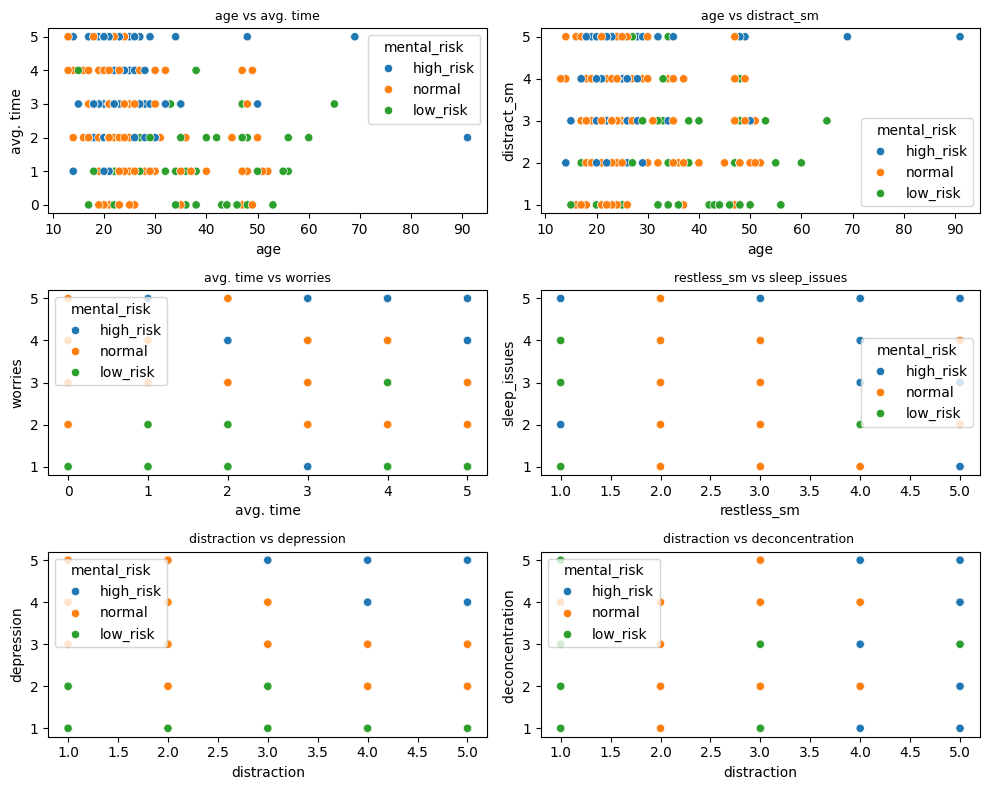

In [ ]:
scatter_pairs = [
    ('age', 'avg. time'),
    ('age', 'distract_sm'),
    ('avg. time', 'worries'),
    ('restless_sm', 'sleep_issues'),
    ('distraction', 'depression'),
    ('distraction', 'deconcentration '),
]

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (x, y) in enumerate(scatter_pairs):
    sns.scatterplot(data=df, x=x, y=y, hue='mental_risk', ax=axes[i])
    axes[i].set_title(f"{x} vs {y}", size=9)
plt.tight_layout()
plt.show()

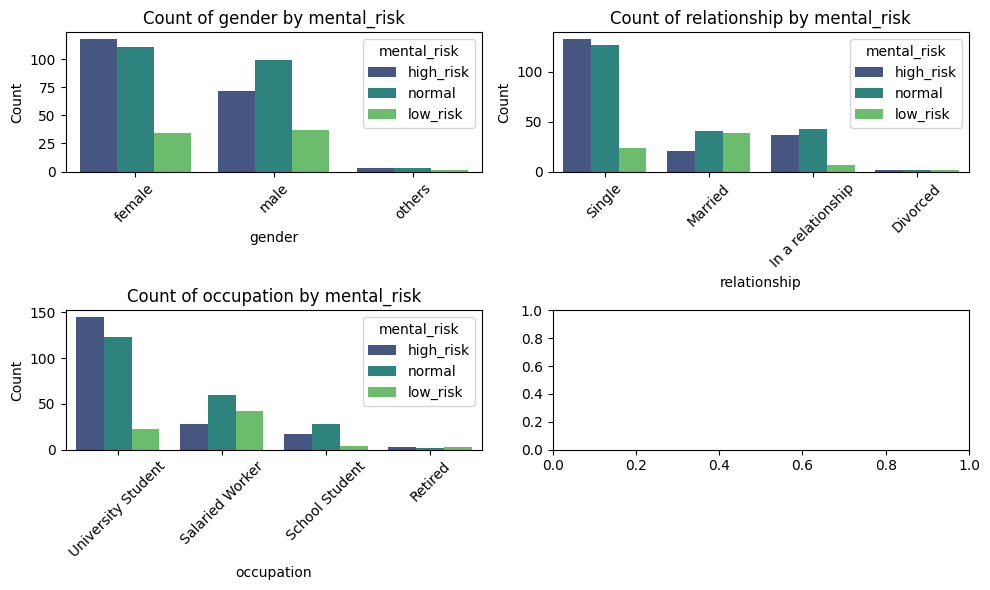

In [ ]:
n_features = len(categorical_features)-1
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
  if col != 'mental_risk':
    sns.countplot(data=df, x=col, hue='mental_risk', palette='viridis', order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count of {col} by mental_risk')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

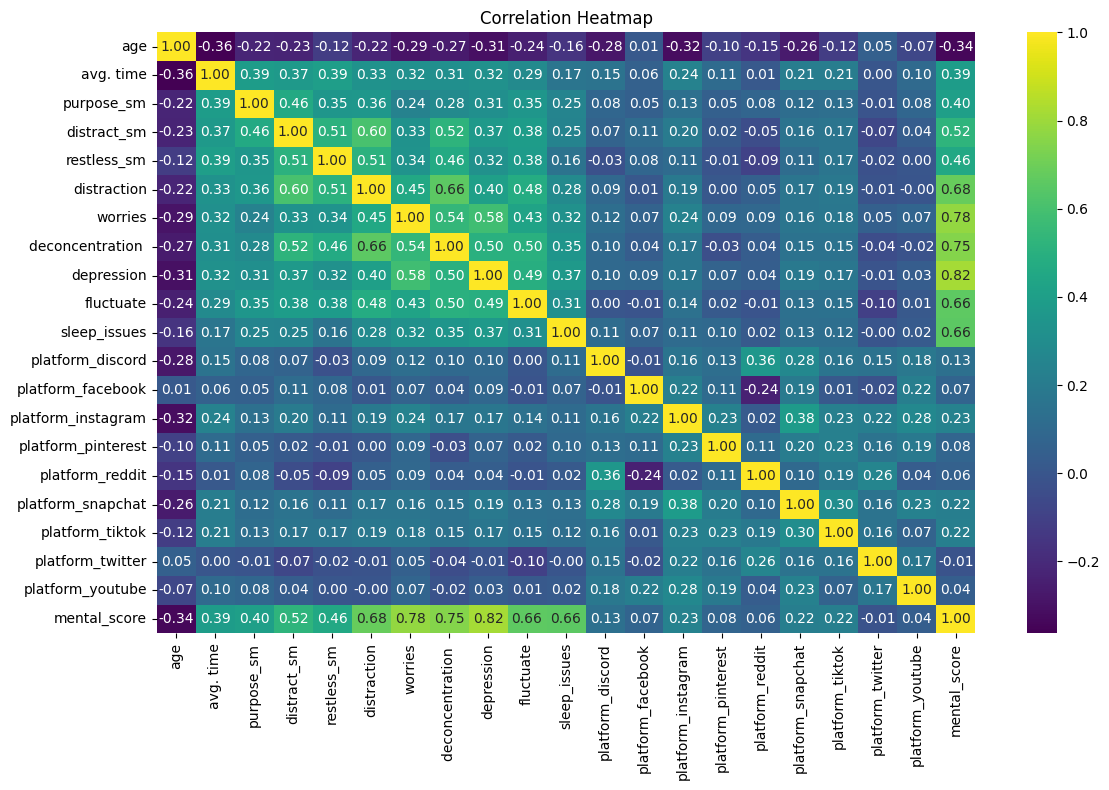

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['age', 'gender', 'relationship', 'occupation', 'avg. time',
       'purpose_sm', 'distract_sm', 'restless_sm', 'distraction', 'worries',
       'deconcentration ', 'depression', 'fluctuate', 'sleep_issues',
       'platform_discord', 'platform_facebook', 'platform_instagram',
       'platform_pinterest', 'platform_reddit', 'platform_snapchat',
       'platform_tiktok', 'platform_twitter', 'platform_youtube',
       'mental_score', 'mental_risk'],
      dtype='object')

## Feature Selection
Separate features into numerical and categorical lists for preprocessing and modeling.


In [ ]:
X = df.drop(columns=['mental_score', 'mental_risk'])
y=df['mental_risk']

In [ ]:
X.shape

(478, 23)

In [ ]:
numerical_features_x = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_x = X.select_dtypes(include=['object']).columns.tolist()

print('numerical features of X: ', numerical_features_x)
print('categorical features of X: ', categorical_features_x)

numerical features of X:  ['age', 'avg. time', 'purpose_sm', 'distract_sm', 'restless_sm', 'distraction', 'worries', 'deconcentration ', 'depression', 'fluctuate', 'sleep_issues', 'platform_discord', 'platform_facebook', 'platform_instagram', 'platform_pinterest', 'platform_reddit', 'platform_snapchat', 'platform_tiktok', 'platform_twitter', 'platform_youtube']
categorical features of X:  ['gender', 'relationship', 'occupation']


## Preprocessing Pipeline
- Numerical: Impute missing values with median, scale with StandardScaler.
- Categorical: Impute missing values with most frequent, encode with OneHotEncoder.
- ColumnTransformer combines numerical and categorical pipelines.


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features_x),
    ('cat', categorical_transformer, categorical_features_x)
])

print("Preprocessor created.")

Preprocessor created.


In [ ]:
X_p = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
print(feature_names)

['num__age' 'num__avg. time' 'num__purpose_sm' 'num__distract_sm'
 'num__restless_sm' 'num__distraction' 'num__worries'
 'num__deconcentration ' 'num__depression' 'num__fluctuate'
 'num__sleep_issues' 'num__platform_discord' 'num__platform_facebook'
 'num__platform_instagram' 'num__platform_pinterest'
 'num__platform_reddit' 'num__platform_snapchat' 'num__platform_tiktok'
 'num__platform_twitter' 'num__platform_youtube' 'cat__gender_female'
 'cat__gender_male' 'cat__gender_others' 'cat__relationship_Divorced'
 'cat__relationship_In a relationship' 'cat__relationship_Married'
 'cat__relationship_Single' 'cat__occupation_Retired'
 'cat__occupation_Salaried Worker' 'cat__occupation_School Student'
 'cat__occupation_University Student']


In [ ]:
label_encoder = LabelEncoder()
y_p = label_encoder.fit_transform(y)
original_class_names = label_encoder.classes_
print("original_class_names: ", original_class_names)

original_class_names:  ['high_risk' 'low_risk' 'normal']


## Train-Test Split
- Stratified split into training, validation, and test sets.
- Apply SMOTE on training data to balance classes.


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X_p, y_p, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (286, 31)
Validation: (96, 31)
Test: (96, 31)


In [ ]:
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Training set after SMOTE:", X_train_res.shape)

Training set after SMOTE: (381, 31)


## Feature Importance
- Train a Random Forest on resampled data.
- Visualize top 30 features influencing predictions.


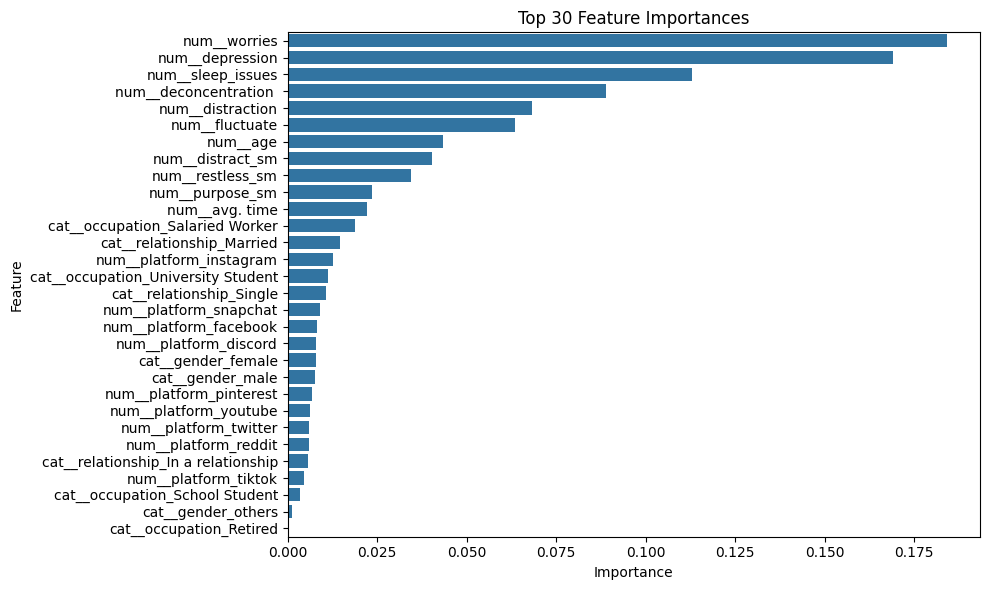

In [ ]:
rf_temp = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=SEED
)

rf_temp.fit(X_train_res, y_train_res)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(30), x='Importance', y='Feature')
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

## Threshold Tuning
- Define a function to optimize probability threshold for detecting the high-risk class.


In [ ]:
n_classes = len(original_class_names)

def tune_threshold(model, X_val, y_val):
    probs = model.predict_proba(X_val)
    best_thr, best_f1 = 0.5, 0

    for thr in np.arange(0.3, 0.7, 0.02):
        HIGH_CLASS = label_encoder.transform(['high_risk'])[0]

        preds = np.argmax(probs, axis=1)
        mask = probs[:, HIGH_CLASS] < thr

        other_classes = [c for c in range(n_classes) if c != HIGH_CLASS]

        preds[mask] = np.argmax(
            probs[mask][:, other_classes],
            axis=1
        )

        f1 = f1_score(y_val, preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1
print("tune_threshold function created.")

tune_threshold function created.


## Train and Evaluate Models
- Train multiple classifiers: Logistic Regression, Random Forest, Extra Trees, AdaBoost, LightGBM, CatBoost, XGBoost.
- Evaluate using Accuracy, Precision, Recall, F1-Score, ROC AUC.
- Display confusion matrices for each model.


In [ ]:
def train_evaluate(model, name):
    model.fit(X_train_res, y_train_res)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1_Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted') if y_proba is not None else np.nan
    }

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=original_class_names,
        cmap='Blues',
        xticks_rotation=45
    )
    disp.ax_.set_title(f"{name} – Confusion Matrix")
    plt.show()

    thr, val_f1 = tune_threshold(model, X_val, y_val)

    return model,metrics,thr,val_f1

print("Train_evaluate function created.")

Train_evaluate function created.


## Model Comparison
- Compare models based on weighted Accuracy and F1 Score.
- Select the best-performing model.


In [ ]:
results = {}
trained_models = {}
val_f1_scores = {}

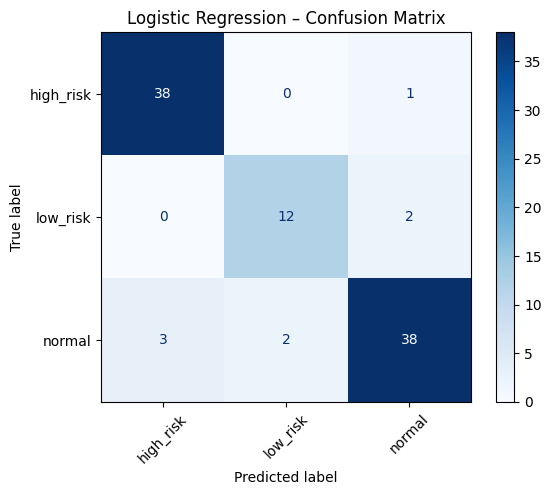

------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression
{'Accuracy': 0.9166666666666666, 'Precision': 0.9166666666666666, 'Recall': 0.9166666666666666, 'F1_Score': 0.9161954365079366, 'ROC_AUC': np.float64(0.9897014933406534)}
Best validation F1: 0.3957
Best threshold: 0.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
l_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
name = "Logistic Regression"
model, metrics,thr,val_f1 = train_evaluate(l_reg, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

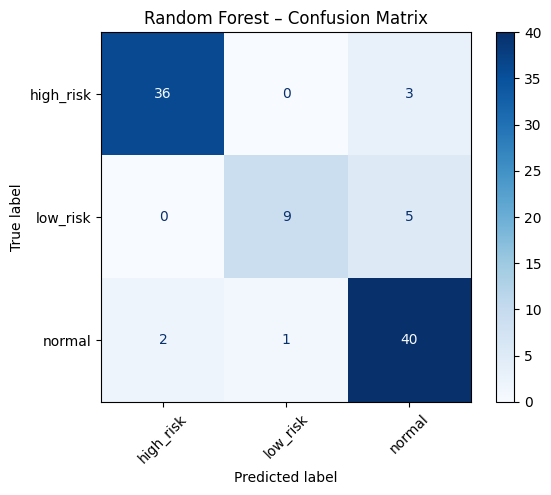

------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest
{'Accuracy': 0.8854166666666666, 'Precision': 0.8893823099415205, 'Recall': 0.8854166666666666, 'F1_Score': 0.8830180236430237, 'ROC_AUC': np.float64(0.9515668437468884)}
Best validation F1: 0.4861
Best threshold: 0.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
r_fore = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=SEED)
name = "Random Forest"
model, metrics,thr,val_f1= train_evaluate(r_fore, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

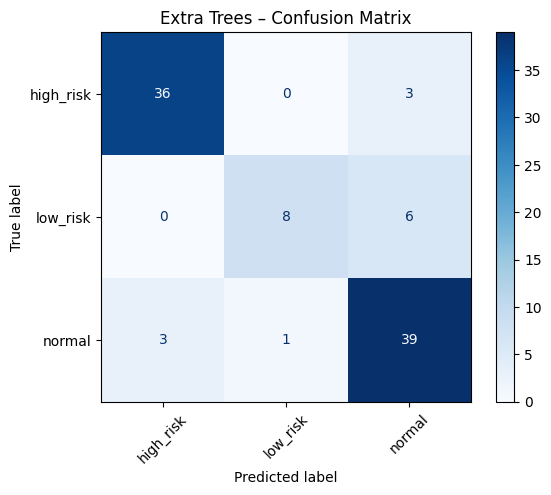

------------------------------------------------------------------------------------------------------------------------------------------------------
Extra Trees
{'Accuracy': 0.8645833333333334, 'Precision': 0.8685619212962963, 'Recall': 0.8645833333333334, 'F1_Score': 0.8603778467908901, 'ROC_AUC': np.float64(0.9531231918575392)}
Best validation F1: 0.5142
Best threshold: 0.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
e_tree = ExtraTreesClassifier(n_estimators=300, class_weight='balanced', random_state=SEED)
name = "Extra Trees"
model, metrics,thr,val_f1 = train_evaluate(e_tree, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

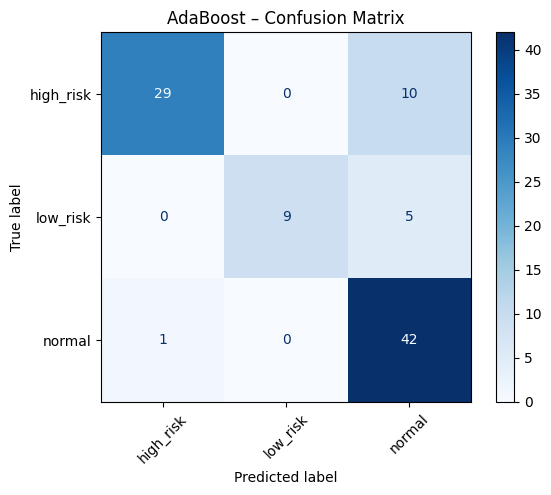

------------------------------------------------------------------------------------------------------------------------------------------------------
AdaBoost
{'Accuracy': 0.8333333333333334, 'Precision': 0.8685855263157896, 'Recall': 0.8333333333333334, 'F1_Score': 0.8318659420289855, 'ROC_AUC': np.float64(0.8859807230147773)}
Best validation F1: 0.7358
Best threshold: 0.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
ad_boos = AdaBoostClassifier(n_estimators=300, random_state=SEED)
name = "AdaBoost"
model, metrics,thr,val_f1 = train_evaluate(ad_boos, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 381, number of used features: 28
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

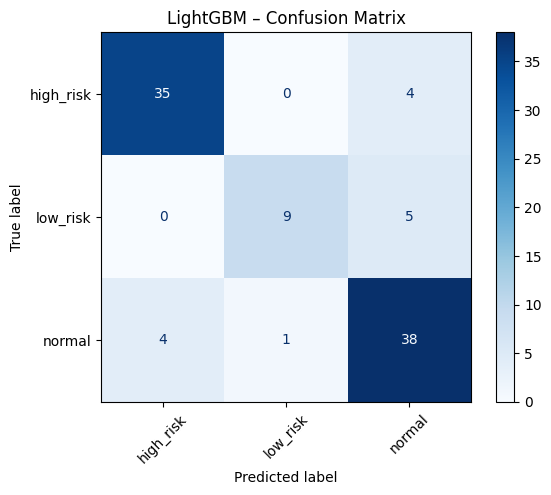

------------------------------------------------------------------------------------------------------------------------------------------------------
LightGBM
{'Accuracy': 0.8541666666666666, 'Precision': 0.8579787234042553, 'Recall': 0.8541666666666666, 'F1_Score': 0.852199074074074, 'ROC_AUC': np.float64(0.9726289701762459)}
Best validation F1: 0.4250
Best threshold: 0.32
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
l_gbm = LGBMClassifier(n_estimators=500, class_weight='balanced', random_state=SEED,force_row_wise=True)
name = "LightGBM"
model, metrics,thr,val_f1 = train_evaluate(l_gbm, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

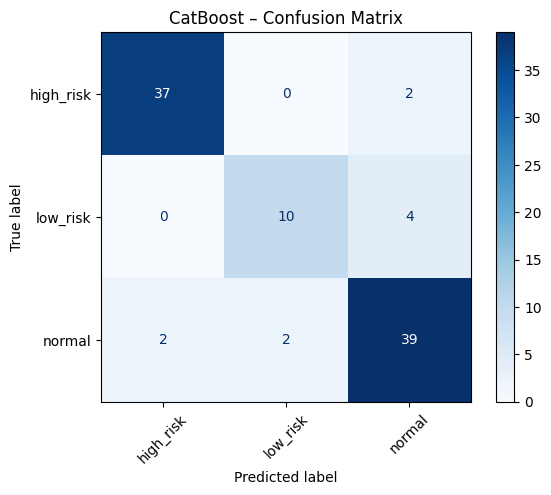

------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost
{'Accuracy': 0.8958333333333334, 'Precision': 0.8951388888888889, 'Recall': 0.8958333333333334, 'F1_Score': 0.8946131993006993, 'ROC_AUC': np.float64(0.9825625264072899)}
Best validation F1: 0.4037
Best threshold: 0.38
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
catboost =  CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=SEED)
name = "CatBoost"
model, metrics,thr,val_f1 = train_evaluate(catboost, name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

In [ ]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=SEED,
    tree_method='hist'
)

xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.1, 0.2]
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_param_grid, n_iter=20,
    cv=StratifiedKFold(5), scoring='f1_weighted',
    verbose=1, random_state=SEED, n_jobs=-1
)
xgb_search.fit(X_train_res, y_train_res)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}


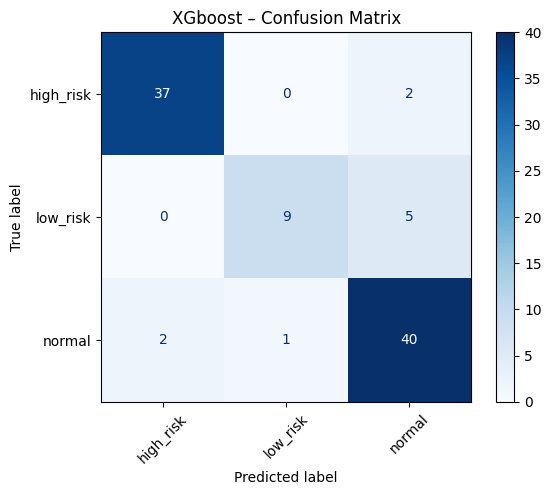

------------------------------------------------------------------------------------------------------------------------------------------------------
XGboost
{'Accuracy': 0.8958333333333334, 'Precision': 0.8978723404255319, 'Recall': 0.8958333333333334, 'F1_Score': 0.8929398148148149, 'ROC_AUC': np.float64(0.9791458520034556)}
Best validation F1: 0.4380
Best threshold: 0.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
name = "XGboost"
model, metrics,thr,val_f1 = train_evaluate(best_xgb,name)
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

## Stacking Ensemble
Combine top-performing models (Random Forest, XGBoost, LightGBM) using a Logistic Regression meta-classifier.


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

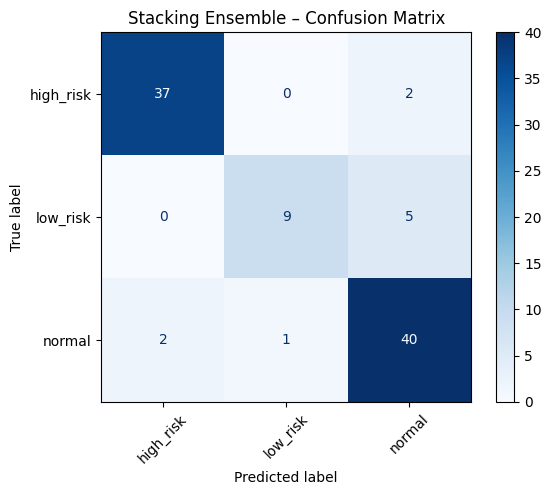

------------------------------------------------------------------------------------------------------------------------------------------------------
Stacking Ensemble
{'Accuracy': 0.8958333333333334, 'Precision': 0.8978723404255319, 'Recall': 0.8958333333333334, 'F1_Score': 0.8929398148148149, 'ROC_AUC': np.float64(0.9675614196559046)}
Best validation F1: 0.4132
Best threshold: 0.32
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
stack_estimators = [
    ('rf', trained_models['Random Forest'][0]),
    ('xgb', trained_models['XGboost'][0]),
    ('lgb', trained_models['LightGBM'][0])
]

stacking_clf = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=5
)

model, metrics,thr,val_f1 = train_evaluate(stacking_clf, "Stacking Ensemble")
name = "Stacking Ensemble"
results[name] = metrics
trained_models[name] = (model,thr)
val_f1_scores[name] = val_f1
print('-'*150)
print(name)
print(metrics)
print(f"Best validation F1: {val_f1:.4f}")
print(f"Best threshold: {thr:.2f}")
print('-'*150)

## Final Model Evaluation
- Retrain best model on combined training and validation sets.
- Evaluate on test set with metrics and confusion matrix.
- Plot per-class and macro-average ROC curves.


In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
results_df

,Accuracy,Precision,Recall,F1_Score,ROC_AUC
Logistic Regression,0.916667,0.916667,0.916667,0.916195,0.989701
Stacking Ensemble,0.895833,0.897872,0.895833,0.892940,0.967561
XGboost,0.895833,0.897872,0.895833,0.892940,0.979146
CatBoost,0.895833,0.895139,0.895833,0.894613,0.982563
Random Forest,0.885417,0.889382,0.885417,0.883018,0.951567
Extra Trees,0.864583,0.868562,0.864583,0.860378,0.953123
LightGBM,0.854167,0.857979,0.854167,0.852199,0.972629
AdaBoost,0.833333,0.868586,0.833333,0.831866,0.885981


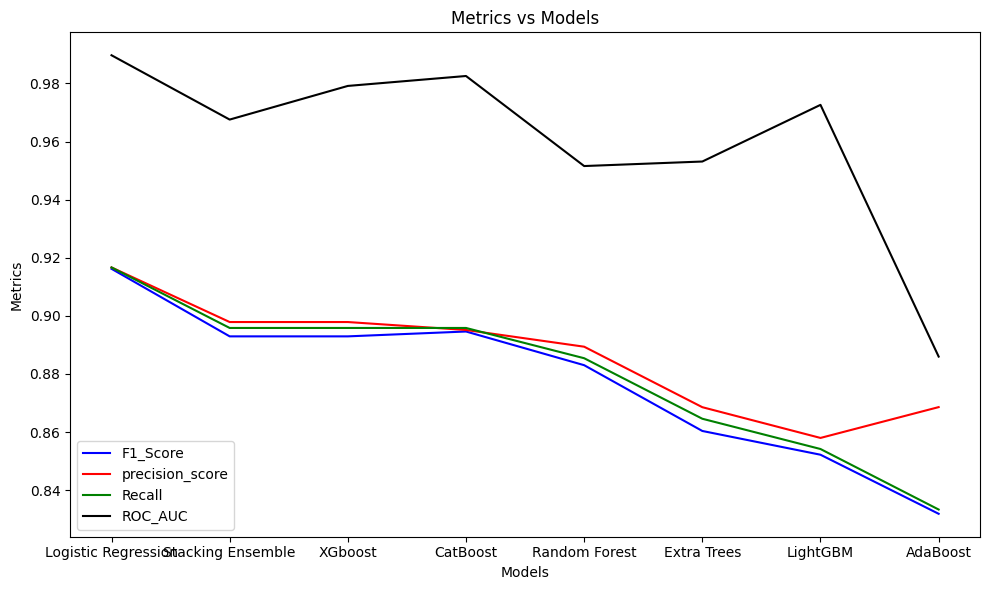

In [ ]:
results_df['F1_Score'].plot(kind='line', figsize=(10, 6), label='F1_Score', color='blue')
results_df['Precision'].plot(kind='line', figsize=(10, 6),label='precision_score', color='red')
results_df['Recall'].plot(kind='line', figsize=(10, 6),label='Recall', color='green')
results_df['ROC_AUC'].plot(kind='line', figsize=(10, 6),label='ROC_AUC', color='black')
plt.gca().spines[['top', 'right']]
plt.title('Metrics vs Models')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
best_model_name = results_df.index[0]
final_model = trained_models[best_model_name]

print("Final Selected Model by accuracy:", best_model_name)

Final Selected Model by accuracy: Logistic Regression


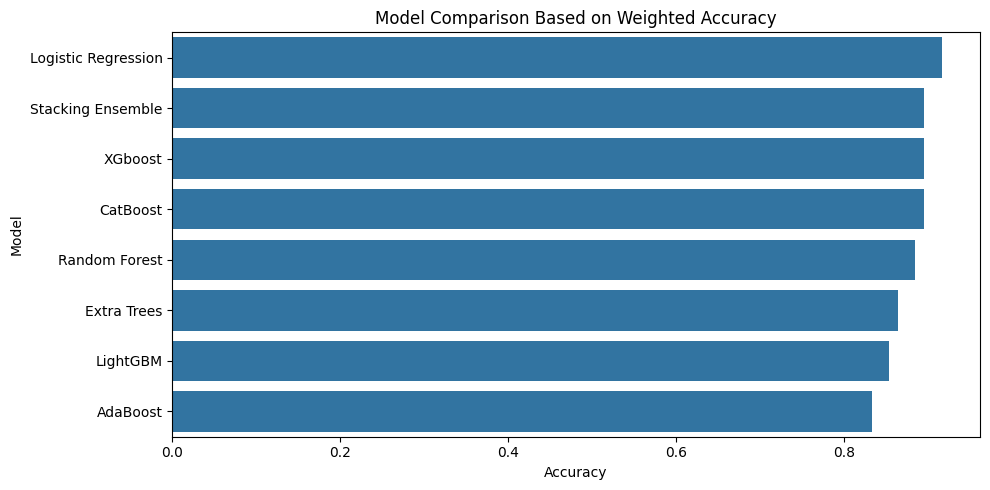

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=results_df['Accuracy'], y=results_df.index)
plt.title("Model Comparison Based on Weighted Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [ ]:
val_f1_scores_df = pd.DataFrame(val_f1_scores, index=['F1 Score']).T.sort_values(by='F1 Score', ascending=False)
val_f1_scores_df

,F1 Score
AdaBoost,0.735804
Extra Trees,0.514239
Random Forest,0.486102
XGboost,0.437988
LightGBM,0.424989
Stacking Ensemble,0.413212
CatBoost,0.403708
Logistic Regression,0.395653


## Explainability
- Apply SHAP to tree-based models for feature-level interpretation.
- Visualize important features influencing mental risk predictions.


In [ ]:
best_model_name = max(val_f1_scores, key=val_f1_scores.get)
best_model, best_thr = trained_models[best_model_name]

print("\nFINAL MODEL after thresholding:", best_model_name)


FINAL MODEL after thresholding: AdaBoost


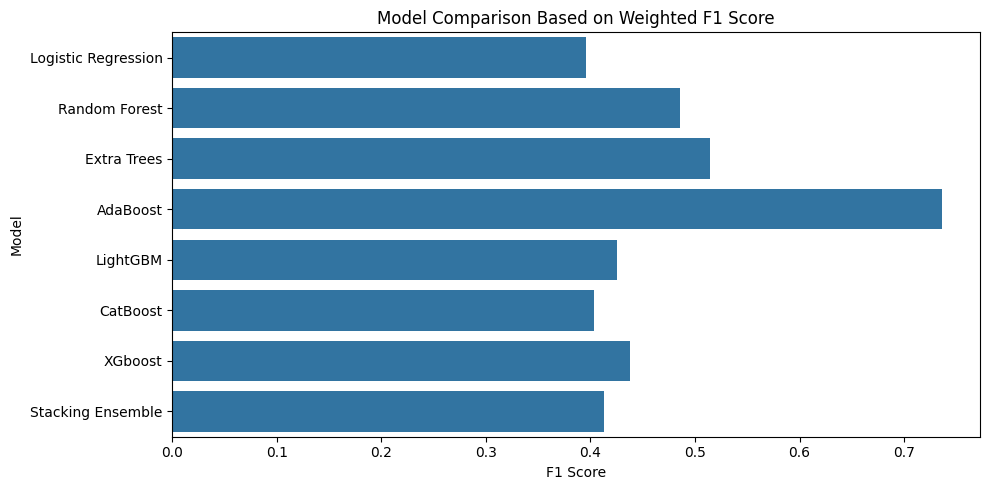

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=val_f1_scores.values(), y=val_f1_scores.keys())
plt.title("Model Comparison Based on Weighted F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/BioFusion/model_comparison_mental_risk__f1.png", dpi=300)
plt.show()



In [ ]:
X_trainval = np.vstack([X_train_res, X_val])
y_trainval = np.hstack([y_train_res, y_val])

best_model.fit(X_trainval, y_trainval)


AdaBoostClassifier(n_estimators=300, random_state=42)


Final Test Metrics
Accuracy: 0.7708333333333334
Precision: 0.754262706855792
Recall: 0.7708333333333334
F1: 0.7572662997795022
ROC AUC: 0.9375582810569912


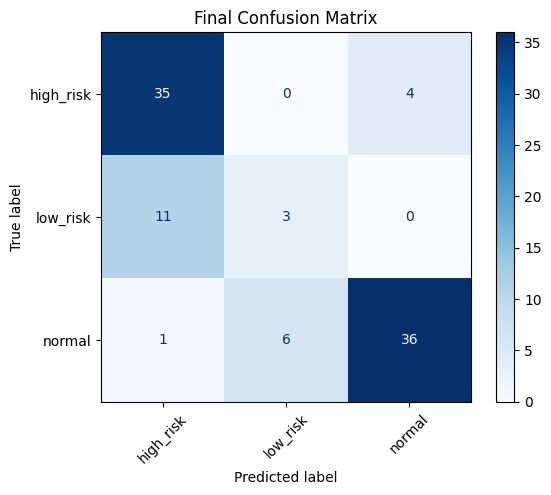

In [ ]:
test_probs = best_model.predict_proba(X_test)
HIGH_CLASS = label_encoder.transform(['high_risk'])[0]

test_preds = np.argmax(test_probs, axis=1)
mask = test_probs[:, HIGH_CLASS] < best_thr

other_classes = [c for c in range(n_classes) if c != HIGH_CLASS]

test_preds[mask] = np.argmax(
    test_probs[mask][:, other_classes],
    axis=1
)

y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

print("\nFinal Test Metrics")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds, average='weighted'))
print("Recall:", recall_score(y_test, test_preds, average='weighted'))
print("F1:", f1_score(y_test, test_preds, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, test_probs, multi_class='ovr', average='weighted'))

ConfusionMatrixDisplay.from_predictions(
    y_test, test_preds,
    display_labels=original_class_names,
    cmap='Blues', xticks_rotation=45
)
plt.title("Final Confusion Matrix")
plt.show()

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

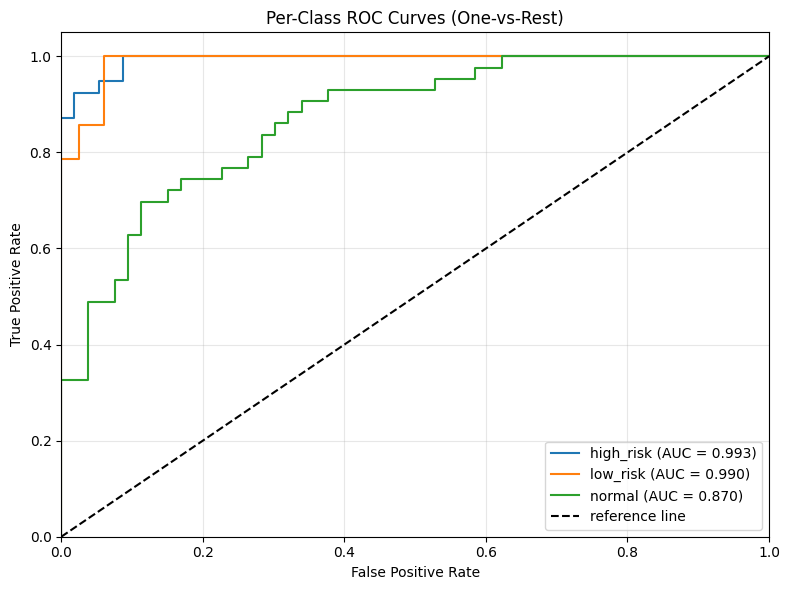

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{original_class_names[i]} (AUC = {roc_auc[i]:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', label='reference line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Per-Class ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


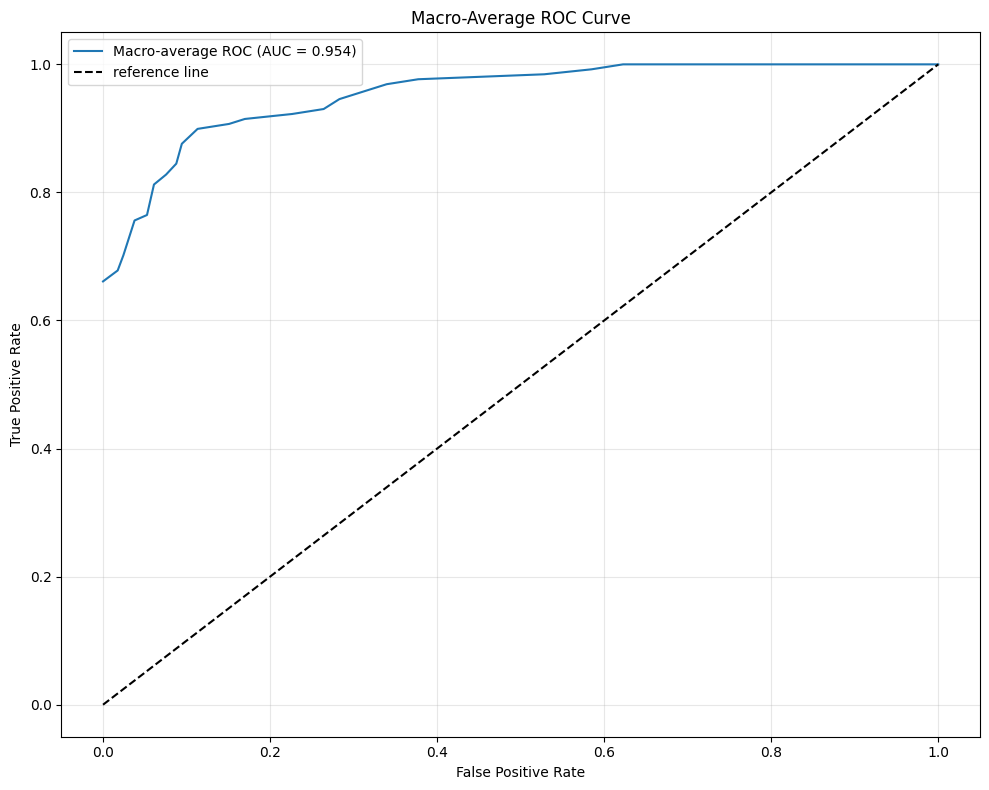

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label = "reference line")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
tree_models = (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    LGBMClassifier,
    CatBoostClassifier,
    XGBClassifier
)

if isinstance(final_model, tree_models):
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_train_res)

    shap.summary_plot(shap_values if isinstance(shap_values, np.ndarray) else shap_values[0],
                      X_train_res, feature_names=feature_names,show=True)



## Save Model
- Export final trained model using joblib for deployment.


In [ ]:
joblib.dump(final_model, "/content/drive/MyDrive/Colab Notebooks/BioFusion/Final_Mental_risk_Prediction_Model.pkl")
print("Final model saved successfully.")

Final model saved successfully.
